In [1]:
from pymongo import MongoClient
import matplotlib.pyplot as plt
import snappy
import numpy as np
from scipy.optimize import curve_fit
%matplotlib inline

In [2]:
client = MongoClient()
dbname = 'xamsdata0'

### Plot a waveform

In [3]:
collname = '170308_122600'

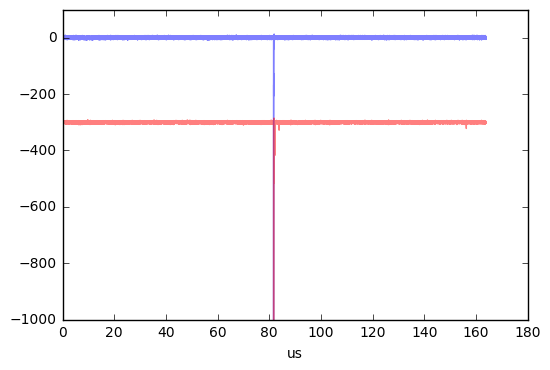

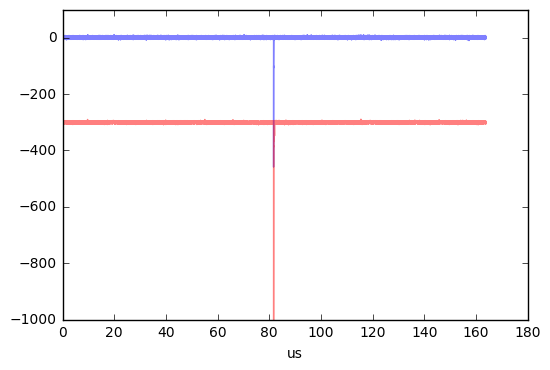

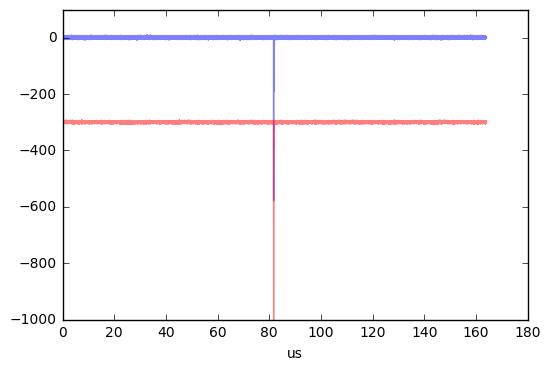

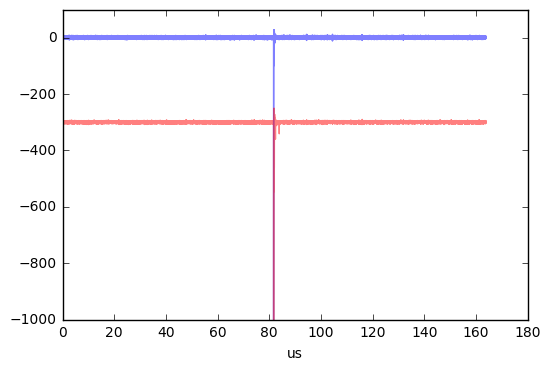

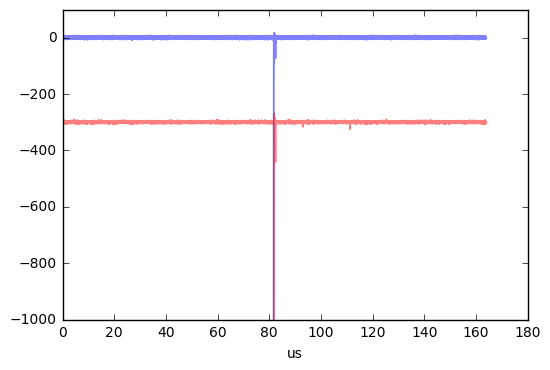

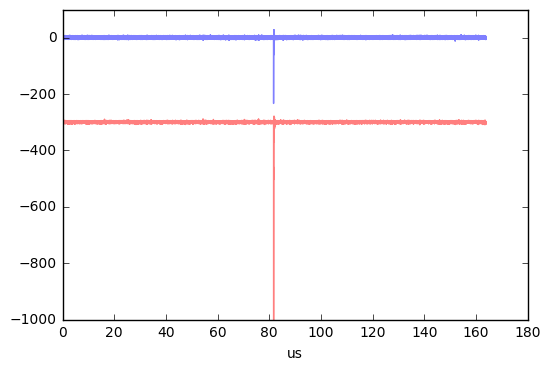

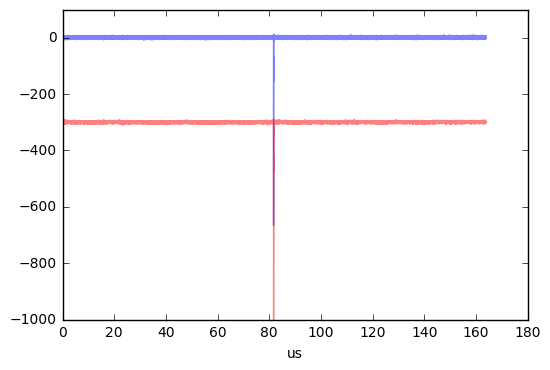

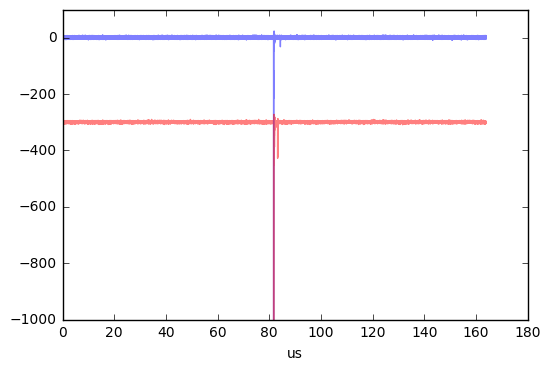

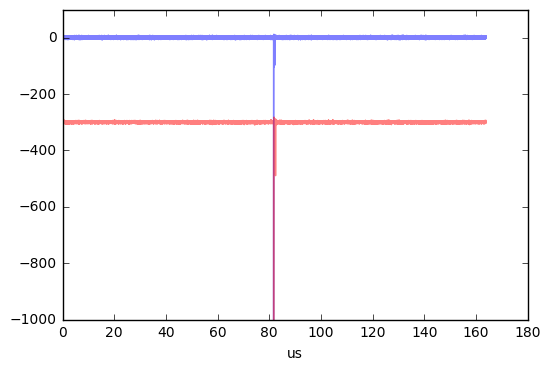

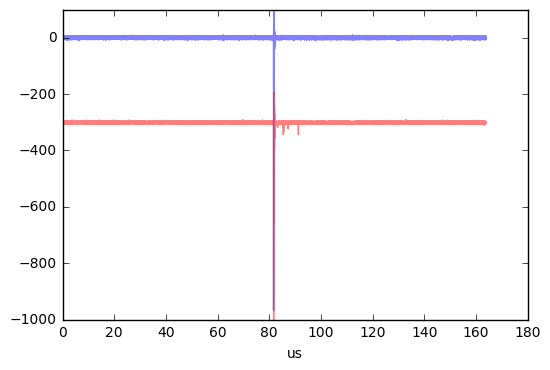

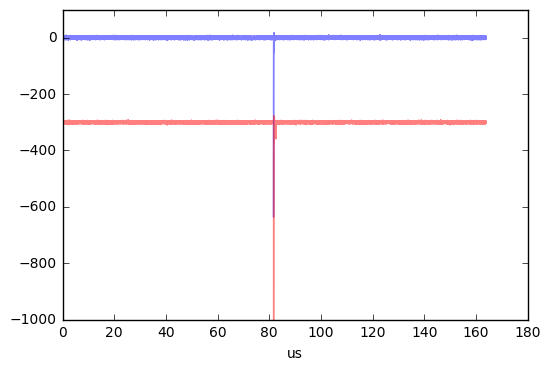

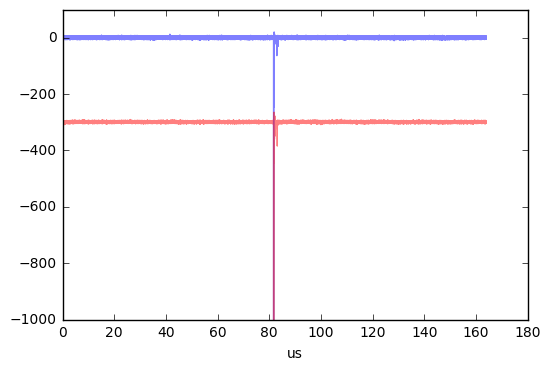

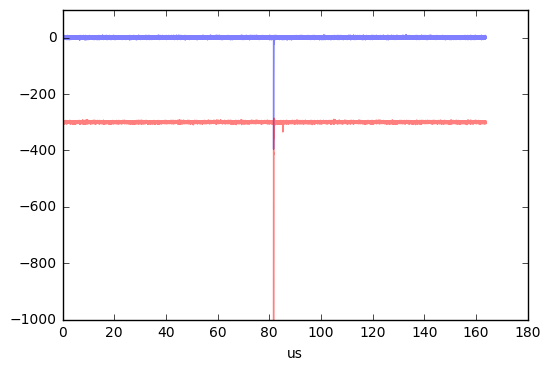

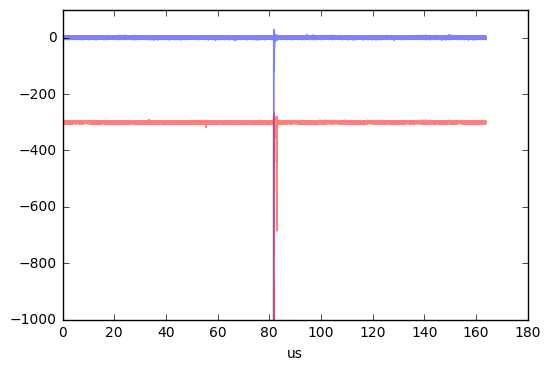

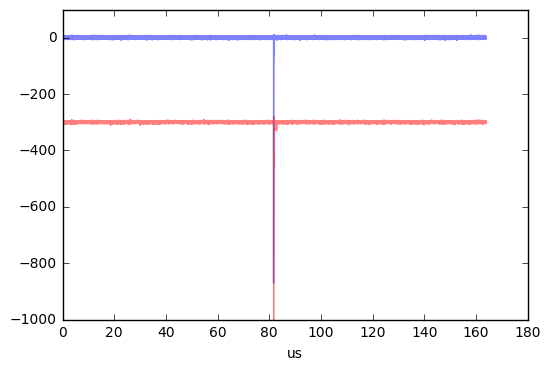

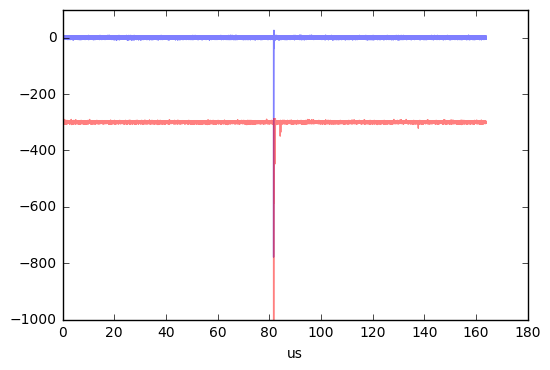

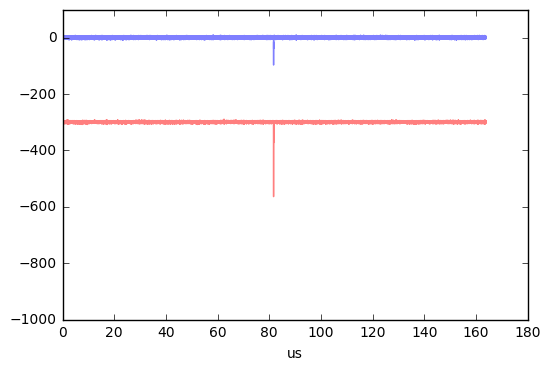

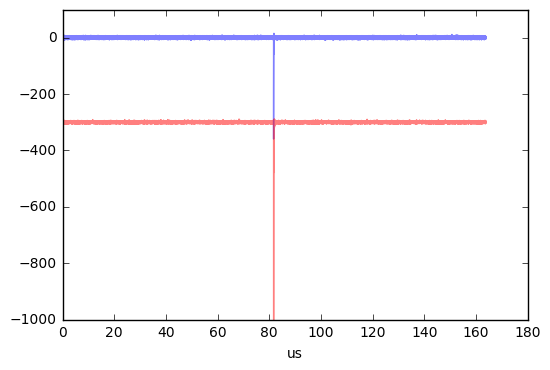

In [9]:
cursor = client[dbname][collname].find()
i = 0
for doc in cursor:
    if i >= 16 and i<=51:
        i_ev = i//2 # 2 channels
        # Get the data
        d = snappy.decompress(doc['data'])
        w = np.fromstring(d, dtype='<i2')

        w_c = w - np.mean(w[:100])
        # 
        if doc['channel'] == 0:
            plt.plot(np.linspace(0, 0.002*len(w_c), len(w_c)),
                     w_c, alpha = 0.5, color = 'blue')
        if doc['channel'] == 3:
            w_c -= 300
            plt.plot(np.linspace(0, 0.002*len(w_c), len(w_c)),
                w_c, alpha = 0.5, color = 'red')
            plt.xlabel('us')
            plt.ylim(-1000,100)
            plt.savefig('signal.pdf', format = 'pdf')
            plt.show()
            
    i+=1

### Noise analysis

In [132]:
# 170227_104148 is 160 microsecond samples of nothing at 1000V for both PMTs, using 0 gain for both
# 170227_122330 is 160 microsecond samples of nothing at 1000V for both PMTs, using 1 gain for both
# The above 2 are baseline mode 0  and 809c (autocal) 1

# 170227_132952 is baseline mode 2
# baselines pretty much the same

# 170227_133203 is same but after ADC reset
# baselines shifted to the right by about 50 counts or so

# baseline_mode 1 leads to error initializing electronics. The baseline files do not exist.
# baseline mode set back to 2

# 170227_134002 is with 8098 at 8000
# 170227_134137 is with 8098 at C000
# 170227_134349 is after reset
# 170227_134711 is with 1098 C000
# 170227_134838 is with 809C 0
# None of these things (except the reset) affect the baselines
# 170227_135429 is with all register settings about baseline removed

# started a bunch of short runs (10s) with standard default ini
# these runs start at 170227_140328 with exactly 20 seconds in between til 170227_140708
# results: 
# 8266 8229
# 8268 8230
# 8266 8229
# 8268 8230
# 8267 8229
# 8267 8230
# 8267 8229
# 8268 8230
# 8266 8229
# So very consistent

# Started a bunch of runs like this but resetting the ADC every time
# These are the runs between 170227_141723 and 170227_143127
# results: 
# 8269 8234
# 8270 8225
# 8271 8232
# 8269 8234
# 8287 8252
# 8267 8232
# 8268 8241
# 8286 8242
# 8269 8218
# 8268 8232


In [3]:
dbname = 'xamsdata0'
collname = '170308_150754'
cursor = client[dbname][collname].find()
i = 0
l = [];
c = []
for doc in cursor:
    d = snappy.decompress(doc['data'])
    w = list(np.fromstring(d, dtype='<i2'))
#     print(doc['channel'])
    l.append(w)
    c.append(doc['channel'])

0
3


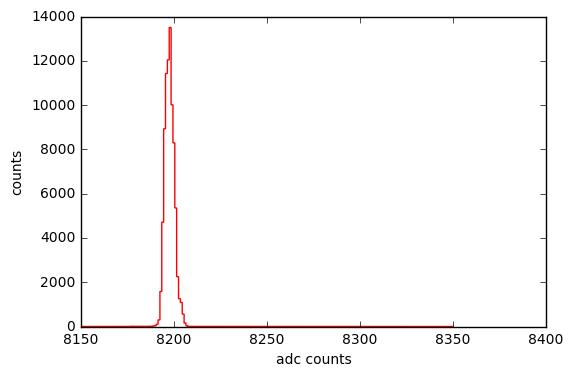

3


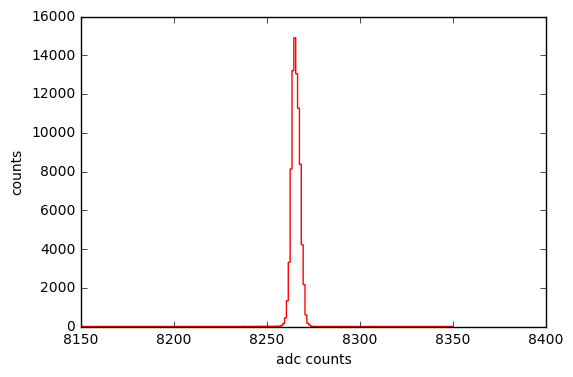

In [6]:
histboundaries = [8150.5,8350.5]
histbinwidth = 1
histbins = np.arange(histboundaries[0], histboundaries[1]+histbinwidth, histbinwidth)
centers = np.arange(histboundaries[0]+histbinwidth/2.0, histboundaries[1], histbinwidth)

print(c[0])
print(c[1])
histpmt2 = plt.hist(l[10], bins=histbins, histtype='step', color = 'red')
plt.xlabel('adc counts')
plt.ylabel('counts')
plt.show()

print(c[1])
histpmt1 = plt.hist(l[11], bins=histbins, histtype='step', color = 'red')
plt.xlabel('adc counts')
plt.ylabel('counts')
plt.show()

counts1 = histpmt1[0]
counts1err = [np.sqrt(c)+1 for c in counts1]
counts2 = histpmt2[0]
counts2err = [np.sqrt(c)+1 for c in counts2]

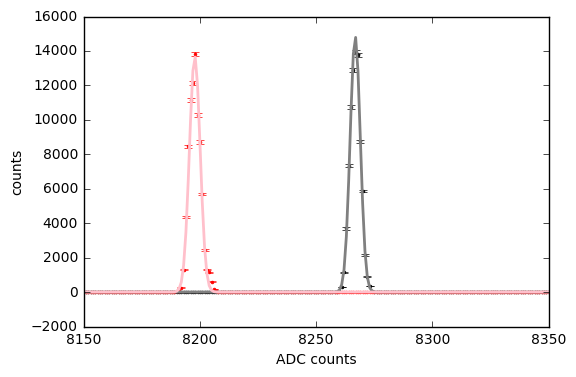

8266.82111232 8197.81776772


In [5]:
def gauss(x, a1, b1, s1):
    return a1 * np.exp(-(x-b1)**2/(2*s1**2))

ag = 12000
bg = 8240
sg = 50

popt1, pcov1 = curve_fit(gauss, centers, counts1, sigma = counts1err, p0=[ag, bg, sg])
perr1 = np.sqrt(np.diag(pcov1))
af1, bf1, sf1 = popt1

popt2, pcov2 = curve_fit(gauss, centers, counts2, sigma = counts2err, p0=[ag, bg, sg])
perr2 = np.sqrt(np.diag(pcov2))
af2, bf2, sf2 = popt2

fitcounts1 = [gauss(t, popt1[0], popt1[1], popt1[2]) for t in centers]
fitcounts2 = [gauss(t, popt2[0], popt2[1], popt2[2]) for t in centers]
gescounts = [gauss(t, ag, bg, sg) for t in centers]

plt.errorbar(centers, counts1, yerr = counts1err, fmt = '.', markersize = 4, color = 'black')
plt.errorbar(centers, counts2, yerr = counts2err, fmt = '.', markersize = 4, color = 'red')
plt.plot(centers, fitcounts1, color='grey', linewidth = 2)
plt.plot(centers, fitcounts2, color='pink', linewidth = 2)
# plt.plot(centers, gescounts, color='black', linewidth = 1)
plt.xlabel("ADC counts")
plt.ylabel("counts")
# plt.yscale('log')
plt.xlim(8150, 8350)
# plt.ylim(0,1)
plt.savefig('gaussness_gain1(donottrustanylikethis)', format='eps')
plt.show()

print(popt1[1], popt2[1])

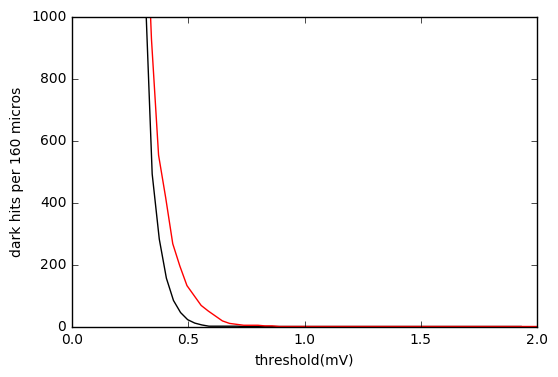

In [262]:
centersheight1 = [(c-popt1[1])*500/16384 for c in centers]
centersheight2 = [(c-popt2[1])*500/16384 for c in centers]
countsheight1 = np.cumsum(counts1[::-1])[::-1]
countsheight2 = np.cumsum(counts2[::-1])[::-1]
plt.plot(centersheight1, countsheight1, color = 'black')
plt.plot(centersheight2, countsheight2, color = 'red')
plt.xlim(0,2)
plt.ylim(0,1000)
plt.xlabel('threshold(mV)')
plt.ylabel('dark hits per 160 micros')
plt.savefig('noise_accept.pdf', format='pdf')
plt.show()

### Baseline scatter plot

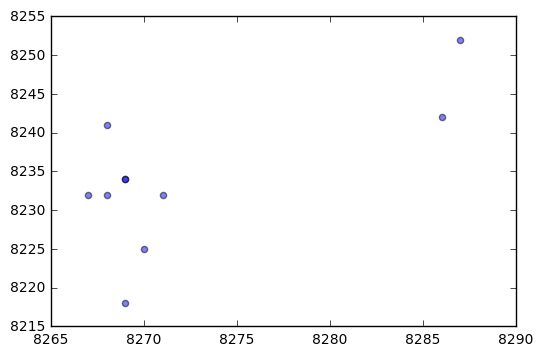

8272.4 7.515909052728677
8234.2 9.342852288722588


In [233]:
baseline1 = [8269, 8270, 8271, 8269, 8287, 8267, 8268, 8286, 8269, 8268]
baseline2 = [8234, 8225, 8232, 8234, 8252, 8232, 8241, 8242, 8218, 8232]

plt.scatter(baseline1, baseline2, alpha=0.5)
plt.savefig('reset_baselines.pdf', format='pdf')
plt.show()

import statistics
print(statistics.mean(baseline1), statistics.stdev(baseline1))
print(statistics.mean(baseline2), statistics.stdev(baseline2))

### Radon analysis

In [136]:
dbname = 'xamsdata0'
collname = '170213_105309'
client[dbname][collname]

Collection(Database(MongoClient(host=['localhost:27017'], document_class=dict, tz_aware=False, connect=True), 'xamsdata0'), '170213_105309')

In [137]:
import pandas as pd
n_events = client[dbname][collname].count()//2
print('Maximum usable events now: %d' % n_events)
    
df = pd.DataFrame({'time': np.zeros(n_events), 
                   'time_ns': np.zeros(n_events, dtype=int), 
                   'baseline_ch0' : np.zeros(n_events),
                   'baseline_ch0_' : np.zeros(n_events),

                   'baseline_ch4' : np.zeros(n_events),
                   'plateau_ch0' : np.zeros(n_events),
                   'max_ch0' : np.zeros(n_events),
                   'min_ch4' : np.zeros(n_events),
                  })
                   

Maximum usable events now: 11703


In [138]:
cursor = client[dbname][collname].find()
i = 0
for doc in cursor:
    if i >= n_events * 2:
        break
    i_ev = i//2 # 2 channels
    # Get the data
    d = snappy.decompress(doc['data'])
    w = np.fromstring(d, dtype='<i2')
    # 
    if doc['channel'] == 0:
        # New event! Let us store all the relevant properties
        df.iloc[i_ev, df.columns.get_loc('time_ns')] = doc['time'] * 4
        df.iloc[i_ev, df.columns.get_loc('time')] = doc['time'] * 4 * 1e-9
        df.iloc[i_ev, df.columns.get_loc('baseline_ch0_')] = np.average(w[:100])
        df.iloc[i_ev, df.columns.get_loc('baseline_ch0')] = np.average(w[:250])

        df.iloc[i_ev, df.columns.get_loc('plateau_ch0')] = np.average(w[400:600])
        df.iloc[i_ev, df.columns.get_loc('max_ch0')] = max(w)
    if doc['channel'] == 4:
        df.iloc[i_ev, df.columns.get_loc('baseline_ch4')] = np.average(w[:100])
        df.iloc[i_ev, df.columns.get_loc('min_ch4')] = max(w)
    i+=1

In [139]:
df['amp'] = df['plateau_ch0'] - df['baseline_ch0']

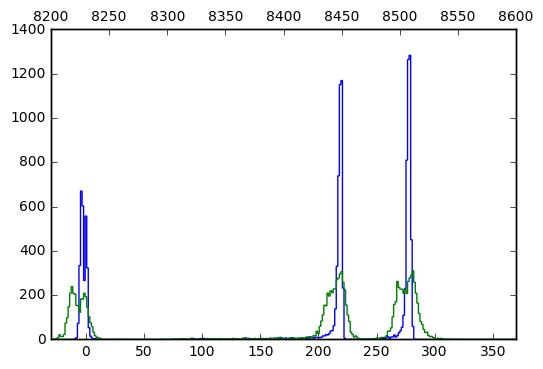

In [140]:
shift = 30
plt.hist(df['amp'], bins=300, histtype='step', 
         range=(-shift,400 - shift))
plt.xlim(-shift,400 - shift)
plt.twiny()
plt.hist(df['plateau_ch0'], bins=300, histtype='step', range=(8200,8600), color='green')
#plt.hist(df['baseline_ch0'], bins=300, histtype='step', range=(8200,8600))

# plt.yscale('log')
# plt.ylim(1,1e3)
plt.show()

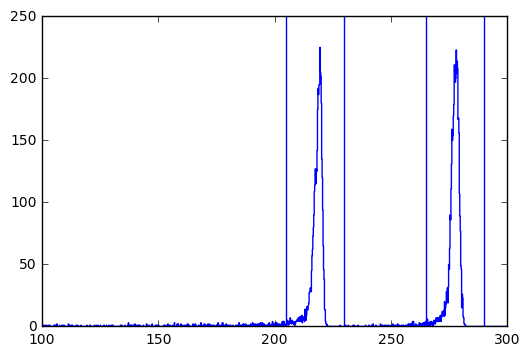

In [141]:
bin_counts, bin_edges, _ = plt.hist(df['amp'], 
                                    bins=1000, histtype='step', range=(100,300))
# plt.yscale('log')
# plt.ylim(1, 4e2)
plt.axvline(205)
plt.axvline(230)

plt.axvline(265)
plt.axvline(290)

plt.show()

In [142]:
def get_peak_properties(start_at, stop_at, bin_counts, bin_edges):
    bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])
    peak0_max = max(bin_counts[start_at:stop_at])
    peak0_index = start_at + np.argmax(bin_counts[start_at:stop_at])
    peak0_pos = bin_centers[peak0_index]
    i = peak0_index
    while bin_counts[i] >= 0.5 * peak0_max:
        i -= 1
    peak0_left = bin_centers[i]
    peak0_left_samples = i
    i = peak0_index
    while bin_counts[i] >= 0.5 * peak0_max:
        i += 1
    peak0_right = bin_centers[i]
    peak0_right_samples = i
    peak0_fwhm = (peak0_right - peak0_left) / peak0_pos * 100
    print('Returning properties of peak found at %.1f amplitude %d' % (peak0_pos, peak0_max))
    print('Total width in samples is %d' % (peak0_right_samples - peak0_left_samples))
    return peak0_fwhm

In [143]:
print(get_peak_properties(0, 700, bin_counts, bin_edges))
print(get_peak_properties(700, 1000, bin_counts, bin_edges))

Returning properties of peak found at 219.5 amplitude 225
Total width in samples is 18
1.64009111617
Returning properties of peak found at 278.1 amplitude 223
Total width in samples is 18
1.29449838188


In [144]:
df_0 = df[(df['amp'] > 205) & (df['amp'] < 230)]
df_1 = df[(df['amp'] > 265) & (df['amp'] < 290)]
print('Events in windows: %d (%.1f %%) and %d (%.1f %%)' % (len(df_0), 100*len(df_0)/len(df),
                                                        len(df_1), 100*len(df_1)/len(df)))

Events in windows: 3986 (34.1 %) and 4372 (37.4 %)


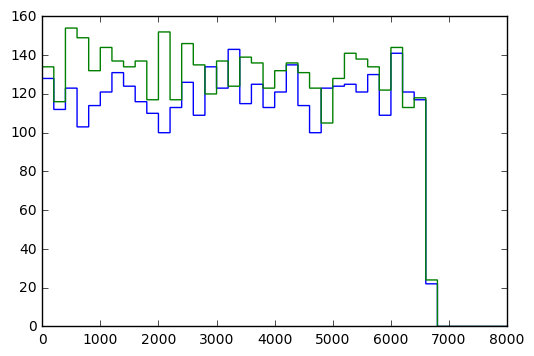

In [145]:
plt.hist(df_0['time'], histtype='step', bins=40, range=(0, 8000))
plt.hist(df_1['time'], histtype='step', bins=40, range=(0, 8000))
plt.yticks()
plt.show()